In [8]:
import time 
import requests
import cv2  
# pip3 install opencv-python
import operator
import numpy as np
import pandas as pd

# Import library to display results
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline 
# Display images within Jupyter

# Variables

_url_emotion = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
_url_face = 'https://api.projectoxford.ai/face/v1.0/detect'
_key_emotion = 'c2e085530b824227a04d474f70b0dde1'
_key_face = '1ea18500dd7c431cb6b8e7a79d20e93d'
_maxNumRetries = 10


headers_emotion = dict()
headers_emotion['Ocp-Apim-Subscription-Key'] = _key_emotion
headers_emotion['Content-Type'] = 'application/octet-stream'

headers_face = dict()
headers_face['Ocp-Apim-Subscription-Key'] = _key_face
headers_face['Content-Type'] = 'application/octet-stream'

In [2]:
def processRequestEmotion( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url_emotion, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [3]:
def processRequestFace( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url_face, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result



In [4]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

In [19]:
cap = cv2.VideoCapture('output.avi')
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

print(length)
json = None
params = None

list_of_dicts = list()
list_of_faces = list()
for i in range(length // 4):
    print(i)
    ret, frame = cap.read()
    if i % 25 != 0:
        continue
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 0:
        continue
    
    file = cv2.imencode('.jpg', frame)[1].tostring()
    
    result = processRequestFace( json, file, headers_emotion, params )
    if len(result) != 0:
        for face in result:  # largest rect
            list_of_faces.append((i, face['faceId'], face['faceRectangle']))
        
        cv2.imwrite('images\\%s.jpg' % i,gray)
    else:
        continue

0


In [12]:
from  collections import defaultdict


counter = defaultdict(int)
for e in list_of_faces:
    counter[e[1]] += 1
max_face_id, max_face_count = max(counter.iteritems(), key=lambda x: x[1])
print(max_face_id, max_face_count)

IndentationError: unexpected indent (<ipython-input-12-c01e747ed079>, line 9)

In [ ]:
for e in list_of_faces:
    if e[1] != max_face_id:
        continue
    i = e[0]
    rect = e[2]

    pathToFileInDisk = r'images\\%s.jpg' % i
    with open( pathToFileInDisk, 'rb' ) as f:
        file = f.read()
        
    json = {'faceRectangles' : rect}
    result = processRequest( json, file, headers_emotion, params )
    
    if len(result) != 0:
        scores = result[0]['scores']
        scores['frame'] = i
        
        list_of_dicts.append(scores)
    
    time.sleep(0.5)

In [139]:
df = pd.DataFrame(list_of_dicts)
df = df.set_index('frame')
df.describe()

,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise
count,1.020000e+02,1.020000e+02,1.020000e+02,1.020000e+02,102.000000,1.020000e+02,1.020000e+02,1.020000e+02
mean,2.533258e-02,7.779042e-04,3.500731e-03,1.384102e-03,0.881631,2.998928e-02,1.613260e-03,5.577108e-02
std,1.147099e-01,2.980491e-03,1.118660e-02,7.325987e-03,0.273166,1.063834e-01,9.116493e-03,1.428507e-01
min,9.026579e-13,1.091195e-13,4.589814e-12,6.590264e-15,0.000003,2.064936e-12,5.190451e-14,4.884418e-11
25%,2.520375e-08,5.939951e-09,3.098541e-07,2.320808e-09,0.958586,2.758943e-07,6.673851e-09,9.481045e-07
50%,1.402727e-06,5.157954e-07,1.322153e-05,1.047495e-06,0.999782,2.959487e-05,1.312736e-06,3.587733e-05
75%,4.022723e-04,6.146219e-05,4.566926e-04,7.000722e-05,0.999993,1.720139e-03,1.160056e-04,1.263912e-02
max,7.587706e-01,2.473738e-02,6.902463e-02,6.104874e-02,1.000000,6.932156e-01,8.932859e-02,8.004259e-01


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11F8A410>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11FFDF70>], dtype=object)

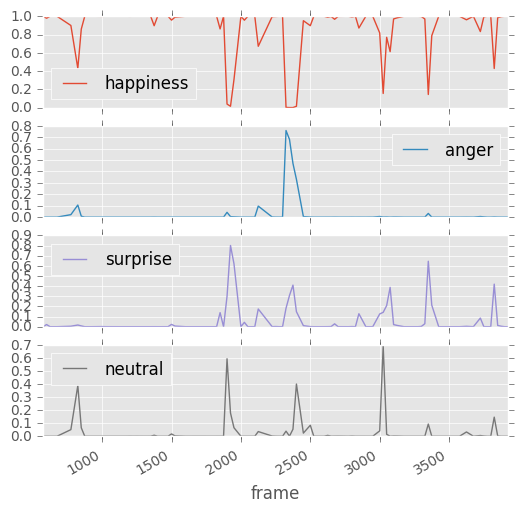

In [169]:
df[['happiness', 'anger', 'surprise', 'neutral']].plot(subplots=True, figsize=(6, 6))

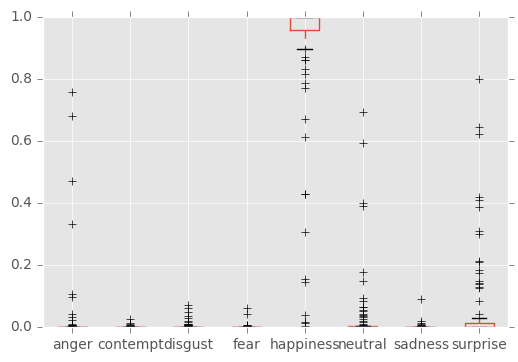

In [162]:
df.plot.box(sym='r+')